In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.metrics import TopKCategoricalAccuracy
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.metrics import classification_report

In [ ]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


# **PREPROCESSING FUNCTIONS FOR OUR MODEL**

In [ ]:
def strip_sequences(df, column_name):
  stripped_seq = df[column_name].apply(lambda x: [item.strip() for item in x.split(",")]).tolist()
  return stripped_seq

In [ ]:
from collections import defaultdict

def markov_mtrx(sequence):

  transitions = defaultdict(lambda: defaultdict(int))

  unique_calls = []
  for i in range(len(sequence) - 1):
    current_call = sequence[i]
    next_call = sequence[i+1]
    transitions[current_call][next_call] += 1
    if current_call not in unique_calls:
      unique_calls.append(current_call)

  df_probabilities = pd.DataFrame(index=unique_calls, columns=unique_calls)

  for row in unique_calls:
      total_transitions = sum(transitions[row].values())
      for col in unique_calls:
          if total_transitions > 0:
              df_probabilities.at[row, col] = transitions[row][col] / total_transitions
          else:
              df_probabilities.at[row, col] = 0

  df_probabilities = df_probabilities.fillna(0)
  return df_probabilities

In [ ]:
def create_markov_mrtx_list(data):
  datalist = []
  for sequence in data:
    datalist.append(markov_mtrx(sequence).values)

  return datalist

In [ ]:
def scale_values(matrix):
  return (matrix * 255).astype(np.uint8)

In [ ]:
from PIL import Image
import numpy as np

def create_image(scaled_matrix):

  # Create a PIL Image object from the array
  image = Image.fromarray(scaled_matrix, mode='L')  # 'L' mode is for grayscale

  return image

In [ ]:
def images_max_size(images):
  tuple_seq = []
  for image in images:
    tuple_seq.append(image.size)

  return max(tuple_seq, key=lambda x: x[1])

In [ ]:
import cv2

def add_padding(image, max_size):
  image_np = np.array(image)

  if image.size == max_size:
    return image
  else:
    pad_width = max_size[0] - image.size[0]
    pad_height = max_size[1] - image.size[1]

    top_pad = pad_height // 2
    bottom_pad = pad_height - top_pad
    left_pad = pad_width // 2
    right_pad = pad_width - left_pad

    padded_image = cv2.copyMakeBorder(image_np, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT, value=0)
    return Image.fromarray(padded_image)

In [ ]:
def convert_images_to_arrays(image_objects):
    image_arrays = []
    for img_obj in image_objects:
        img_array = np.array(img_obj)
        image_arrays.append(img_array)
    return np.array(image_arrays)

In [ ]:
def build_CNN(outputs, height, width, channels):

  model = models.Sequential()

  # Convolutional layers
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, channels)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  # Flatten the output for the fully connected layers
  model.add(layers.Flatten())

  #8 mio 13 filippo
  # Dense (fully connected) layers
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(outputs, activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

# **OUR MODEL WITH OUR DATASET**

* #### **Time needed:** 0:19:19
* #### **Precision:** 0.8683
* #### **Accuracy:** 0.8454
* #### **Recall:** 0.8484
* #### **F1-Score:** 0.8453

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Samples/Family_Dataset.csv")
df.info()

In [ ]:
label_counts = df['Label'].value_counts()

plt.bar(label_counts.index.astype(int), label_counts.values)

plt.xlabel('Family')
plt.ylabel('Number of Samples')
plt.title('Original Multiclass Classification Dataset')

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], ["Benign", "Conti", "Hive", "Lockbit", "Loki", "Msil", "Nitro", "Sodinokibi"])

for i, count in enumerate(label_counts.values):
    plt.text(label_counts.index[i], count, str(count), ha='center', va='bottom')

plt.show()

In [ ]:
df.dropna(inplace=True)

X = df.drop('Label', axis=1)
y = df['Label']

rus = RandomUnderSampler(sampling_strategy='not minority', random_state=22)

X_resampled, y_resampled = rus.fit_resample(X, y)

df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['Label'])], axis=1)

In [ ]:
label_counts = df['Label'].value_counts()

plt.bar(label_counts.index.astype(int), label_counts.values)

plt.xlabel('Family')
plt.ylabel('Number of Samples')
plt.title('Preprocessed Multiclass Classification Dataset')

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7,8,9,10,11,12])

for i, count in enumerate(label_counts.values):
    plt.text(label_counts.index[i], count, str(count), ha='center', va='bottom')

plt.show()

In [ ]:
data = strip_sequences(df=df, column_name="Sequence")
a = create_markov_mrtx_list(data)
scaled_a = []

for element in a:
  scaled_a.append(scale_values(element))

In [ ]:
images_a = []
for i in scaled_a:
  images_a.append(create_image(i))

In [ ]:
padded_imgs = []
for image in images_a:
  padded_imgs.append(add_padding(image, images_max_size(images_a)))

In [ ]:
df["Image"] = images_a

In [ ]:
df["Padded_Image"] = padded_imgs

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
import datetime

precisions = []
accuracies = []
recalls = []
f1s = []

avg_p = []
avg_a = []
avg_r = []
avg_f = []

start_time = datetime.datetime.now()

for i in range(10):
  print("Running iteration number:", i)
  X, y = convert_images_to_arrays(df["Padded_Image"]), np.array(df["Label"].tolist())

  num_folds = 5
  kf = KFold(n_splits=num_folds, shuffle=True, random_state=22)

  model = build_CNN(8, 123, 123, 1)

  fold_number = 1
  for train_index, test_index in kf.split(X):

    print(f"Fold: {fold_number}")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)

    predictions = model.predict(X_test)

    multiclass_predictions = np.argmax(predictions, axis=1)

    # Eval
    precision = precision_score(y_test, multiclass_predictions, average='weighted')
    accuracy = accuracy_score(y_test, multiclass_predictions)
    recall = recall_score(y_test, multiclass_predictions, average='weighted')
    f1 = f1_score(y_test, multiclass_predictions, average='weighted')

    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    f1s.append(f1)

    fold_number = fold_number + 1

  avg_p.append(np.mean(precisions))
  avg_a.append(np.mean(accuracies))
  avg_r.append(np.mean(recalls))
  avg_f.append(np.mean(f1s))

end_time = datetime.datetime.now()
elapsed_time = end_time - start_time

In [ ]:
print(f'The time needed is: {elapsed_time}')
print(f'The precision mean after 10 runs is: {np.mean(avg_p)}')
print(f'The accuracy mean after 10 runs is: {np.mean(avg_a)}')
print(f'The recall mean after 10 runs is: {np.mean(avg_r)}')
print(f'The F1 mean after 10 runs is: {np.mean(avg_f)}')

## Only to save the images

In [ ]:
for index, row in df.iterrows():
    name = row['Name']
    img = row['Padded_Image']
    if row['Label'] == 0:
      img.save("/content/drive/MyDrive/Samples/Imgs/Family_Imgs/Padded/Safe/"+name.strip(".json")+".jpeg")
    elif row['Label'] == 1:
      img.save("/content/drive/MyDrive/Samples/Imgs/Family_Imgs/Padded/Conti/"+name.strip(".json")+".jpeg")
    elif row['Label'] == 2:
      img.save("/content/drive/MyDrive/Samples/Imgs/Family_Imgs/Padded/Hive/"+name.strip(".json")+".jpeg")
    elif row['Label'] == 3:
      img.save("/content/drive/MyDrive/Samples/Imgs/Family_Imgs/Padded/Lockbit/"+name.strip(".json")+".jpeg")
    elif row['Label'] == 4:
        img.save("/content/drive/MyDrive/Samples/Imgs/Family_Imgs/Padded/Loki/"+name.strip(".json")+".jpeg")
    elif row['Label'] == 5:
      img.save("/content/drive/MyDrive/Samples/Imgs/Family_Imgs/Padded/Msil/"+name.strip(".json")+".jpeg")
    elif row['Label'] == 6:
      img.save("/content/drive/MyDrive/Samples/Imgs/Family_Imgs/Padded/Nitro/"+name.strip(".json")+".jpeg")
    elif row['Label'] == 7:
      img.save("/content/drive/MyDrive/Samples/Imgs/Family_Imgs/Padded/Sodinokibi/"+name.strip(".json")+".jpeg")

# **OUR MODEL WITH COGLIO'S DATASET**

* #### **Time needed:** 3:33:49
* #### **Precision:** 0.8414
* #### **Accuracy:** 0.8229
* #### **Recall:** 0.8229
* #### **F1-Score:** 0.8239

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Samples/Comparison/Filippo_Dataset_for_My_Model.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5203 entries, 0 to 5202
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Name      5203 non-null   object
 1   Sequence  5194 non-null   object
 2   Label     5203 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 122.1+ KB


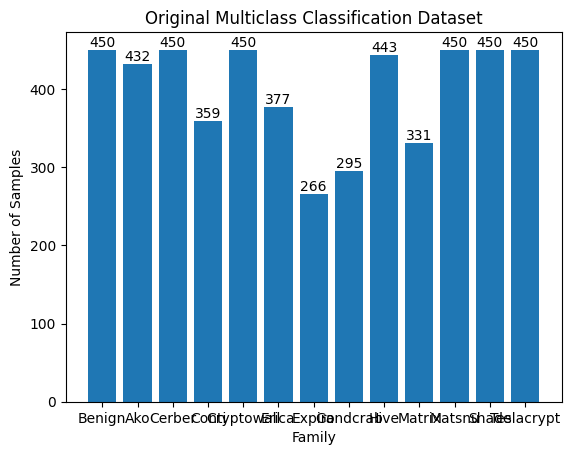

In [ ]:
label_counts = df['Label'].value_counts()

plt.bar(label_counts.index.astype(int), label_counts.values)

plt.xlabel('Family')
plt.ylabel('Number of Samples')
plt.title('Original Multiclass Classification Dataset')

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ["Benign", "Ako", "Cerber", "Conti", "Cryptowall", "Erica", "Expiro", "Gandcrab", "Hive", "Matrix", "Matsnu", "Shade", "Teslacrypt"])

for i, count in enumerate(label_counts.values):
    plt.text(label_counts.index[i], count, str(count), ha='center', va='bottom')

plt.show()

In [ ]:
df.dropna(inplace=True)

X = df.drop('Label', axis=1)
y = df['Label']

rus = RandomUnderSampler(sampling_strategy='not minority', random_state=22)

X_resampled, y_resampled = rus.fit_resample(X, y)

df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['Label'])], axis=1)

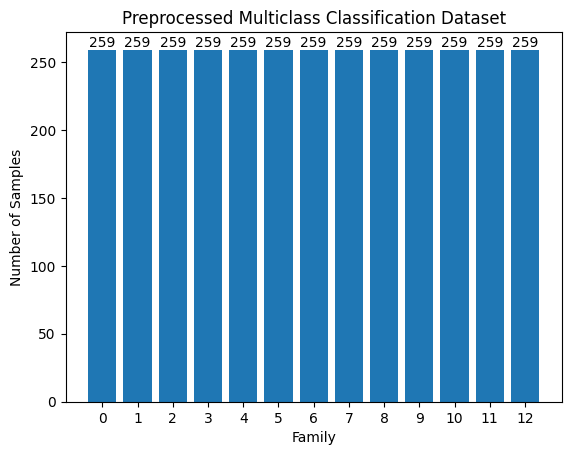

In [ ]:
label_counts = df['Label'].value_counts()

plt.bar(label_counts.index.astype(int), label_counts.values)

plt.xlabel('Family')
plt.ylabel('Number of Samples')
plt.title('Preprocessed Multiclass Classification Dataset')

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

for i, count in enumerate(label_counts.values):
    plt.text(label_counts.index[i], count, str(count), ha='center', va='bottom')

plt.show()

In [ ]:
data = strip_sequences(df=df, column_name="Sequence")
a = create_markov_mrtx_list(data)
scaled_a = []

for element in a:
  scaled_a.append(scale_values(element))

In [ ]:
images_a = []
for i in scaled_a:
  images_a.append(create_image(i))

In [ ]:
padded_imgs = []
for image in images_a:
  padded_imgs.append(add_padding(image, images_max_size(images_a)))

In [ ]:
df["Image"] = images_a

In [ ]:
df["Padded_Image"] = padded_imgs

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
import datetime

precisions = []
accuracies = []
recalls = []
f1s = []

avg_p = []
avg_a = []
avg_r = []
avg_f = []

start_time = datetime.datetime.now()

for i in range(10):
  print("Running iteration number:", i)
  X, y = convert_images_to_arrays(df["Padded_Image"]), np.array(df["Label"].tolist())

  num_folds = 10
  kf = KFold(n_splits=num_folds, shuffle=True, random_state=22)

  model = build_CNN(13, 136, 136, 1)

  fold_number = 1
  for train_index, test_index in kf.split(X):

    print(f"Fold: {fold_number}")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)

    predictions = model.predict(X_test)

    multiclass_predictions = np.argmax(predictions, axis=1)

    # Eval
    precision = precision_score(y_test, multiclass_predictions, average='weighted')
    accuracy = accuracy_score(y_test, multiclass_predictions)
    recall = recall_score(y_test, multiclass_predictions, average='weighted')
    f1 = f1_score(y_test, multiclass_predictions, average='weighted')

    precisions.append(precision)
    accuracies.append(accuracy)
    recalls.append(recall)
    f1s.append(f1)

    fold_number = fold_number + 1

  avg_p.append(np.mean(precisions))
  avg_a.append(np.mean(accuracies))
  avg_r.append(np.mean(recalls))
  avg_f.append(np.mean(f1s))

end_time = datetime.datetime.now()
elapsed_time = end_time - start_time

Running iteration number: 0
Fold: 1
11/11 [==============================] - 3s 283ms/step
Fold: 2
11/11 [==============================] - 3s 237ms/step
Fold: 3
11/11 [==============================] - 3s 284ms/step
Fold: 4
11/11 [==============================] - 3s 234ms/step
Fold: 5
11/11 [==============================] - 3s 239ms/step
Fold: 6
11/11 [==============================] - 3s 234ms/step
Fold: 7
11/11 [==============================] - 3s 235ms/step
Fold: 8
11/11 [==============================] - 3s 241ms/step
Fold: 9
11/11 [==============================] - 3s 309ms/step
Fold: 10
11/11 [==============================] - 3s 280ms/step
Running iteration number: 1
Fold: 1
11/11 [==============================] - 3s 242ms/step
Fold: 2
11/11 [==============================] - 3s 241ms/step
Fold: 3
11/11 [==============================] - 3s 239ms/step
Fold: 4
11/11 [==============================] - 3s 243ms/step
Fold: 5
11/11 [==============================] - 3s 245ms/ste

In [ ]:
print(f'The time needed is: {elapsed_time}')
print(f'The precision mean after 10 runs is: {np.mean(avg_p)}')
print(f'The accuracy mean after 10 runs is: {np.mean(avg_a)}')
print(f'The recall mean after 10 runs is: {np.mean(avg_r)}')
print(f'The F1 mean after 10 runs is: {np.mean(avg_f)}')

The time needed is: 3:33:49.483506
The precision mean after 10 runs is: 0.841435522568845
The accuracy mean after 10 runs is: 0.8229143457539626
The recall mean after 10 runs is: 0.8229143457539626
The F1 mean after 10 runs is: 0.8237692382019176


# **COGLIO'S MODEL WITH OUR DATASET**

* #### **Time needed:** 0.03.32
* #### **Precision:** 0.8820
* #### **Accuracy:** 0.8743
* #### **Recall:** 0.8743
* #### **F1-Score:** 0.8740

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Samples/Comparison/My_Comparison_Multiclass_Dataset.csv")
df.info()

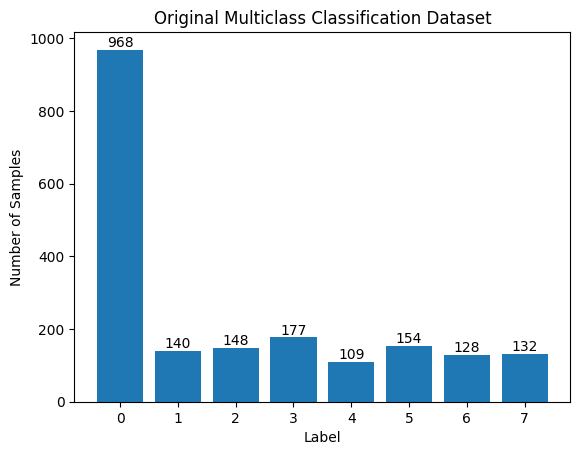

In [ ]:
label_counts = df['Family'].value_counts()

plt.bar(label_counts.index.astype(int), label_counts.values)

plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.title('Original Multiclass Classification Dataset')

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7])

for i, count in enumerate(label_counts.values):
    plt.text(label_counts.index[i], count, str(count), ha='center', va='bottom')

plt.show()

In [ ]:
df.dropna(inplace=True)

X = df.drop('Family', axis=1)
y = df['Family']

rus = RandomUnderSampler(sampling_strategy='not minority', random_state=22)

X_resampled, y_resampled = rus.fit_resample(X, y)

df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['Family'])], axis=1)

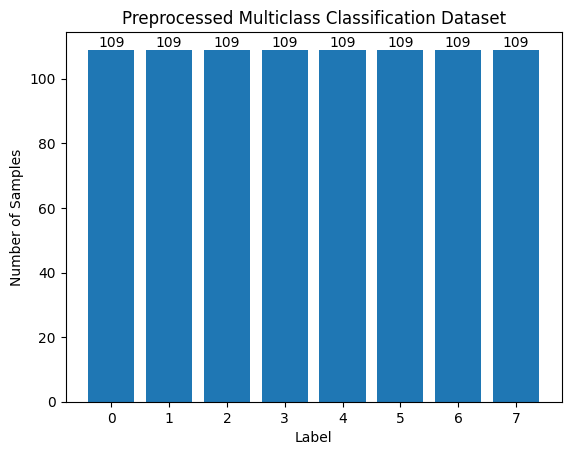

In [ ]:
label_counts = df['Family'].value_counts()

plt.bar(label_counts.index.astype(int), label_counts.values)

plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.title('Preprocessed Multiclass Classification Dataset')

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7])

for i, count in enumerate(label_counts.values):
    plt.text(label_counts.index[i], count, str(count), ha='center', va='bottom')

plt.show()

In [ ]:
data = df.to_numpy()
x = data[:, :-1].astype(float)
y = data[:, -1].astype(float)

In [ ]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
import datetime

y_cat = to_categorical(y)
start_time = datetime.datetime.now()

avg_p = []
avg_a = []
avg_r = []
avg_f = []

for i in range(10):
  print("Running iteration number:", i)
  x_train, x_test, y_train, y_test = train_test_split(x, y_cat, test_size=0.2)

  model = Sequential()
  model.add(Dense(512, input_dim=66, activation = "relu"))
  model.add(Dense(256, activation = "relu"))
  model.add(Dense(128, activation = "relu"))
  model.add(Dropout(0.2))
  model.add(Dense(8, activation = "softmax"))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', TopKCategoricalAccuracy(k=3)])
  model.fit(x_train, y_train, verbose=1, epochs=100, batch_size=30)

  predict_x=model.predict(x_test)
  y_pred_class=np.argmax(predict_x,axis=1)

  y_pred = model.predict(x_test)
  y_test_class = np.argmax(y_test, axis=1)

  precision = precision_score(y_test_class, y_pred_class, average='weighted')
  accuracy = accuracy_score(y_test_class, y_pred_class)
  recall = recall_score(y_test_class, y_pred_class, average='weighted')
  f1 = f1_score(y_test_class, y_pred_class, average='weighted')

  avg_p.append(precision)
  avg_a.append(accuracy)
  avg_r.append(recall)
  avg_f.append(f1)

end_time = datetime.datetime.now()
elapsed_time = end_time - start_time

In [ ]:
print(f'The time needed is: {elapsed_time}')
print(f'The precision mean after 10 runs is: {np.mean(avg_p)}')
print(f'The accuracy mean after 10 runs is: {np.mean(avg_a)}')
print(f'The recall mean after 10 runs is: {np.mean(avg_r)}')
print(f'The F1 mean after 10 runs is: {np.mean(avg_f)}')

The time needed is: 0:03:32.441936
The precision mean after 10 runs is: 0.8819656256477348
The accuracy mean after 10 runs is: 0.8742857142857142
The recall mean after 10 runs is: 0.8742857142857142
The F1 mean after 10 runs is: 0.8739533707545923


# **COGLIO'S MODEL WITH COGLIO'S DATASET**

* #### **Time needed:** 0.10:42
* #### **Precision:** 0.7683
* #### **Accuracy:** 0.7484
* #### **Recall:** 0.7483
* #### **F1-Score:** 0.7508

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Samples/Comparison/dataset_categorical_wo_zero.csv')
blacklist = [1,4,10,12,18,20,22,21,11,16,19]
dataset_cropped = dataset.drop(dataset[dataset['Family'].isin(blacklist)].index)

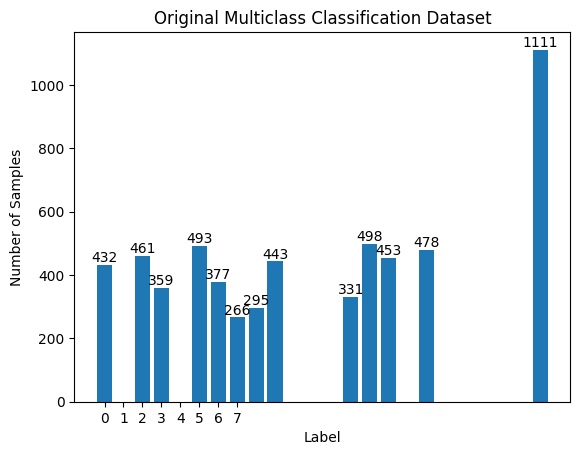

In [ ]:
label_counts = dataset_cropped['Family'].value_counts()

plt.bar(label_counts.index.astype(int), label_counts.values)

plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.title('Original Multiclass Classification Dataset')

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7])

for i, count in enumerate(label_counts.values):
    plt.text(label_counts.index[i], count, str(count), ha='center', va='bottom')

plt.show()

In [ ]:
dataset_cropped.dropna(inplace=True)

X = dataset_cropped.drop('Family', axis=1)
y = dataset_cropped['Family']

rus = RandomUnderSampler(sampling_strategy='not minority', random_state=22)

X_resampled, y_resampled = rus.fit_resample(X, y)

dataset_cropped = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['Family'])], axis=1)

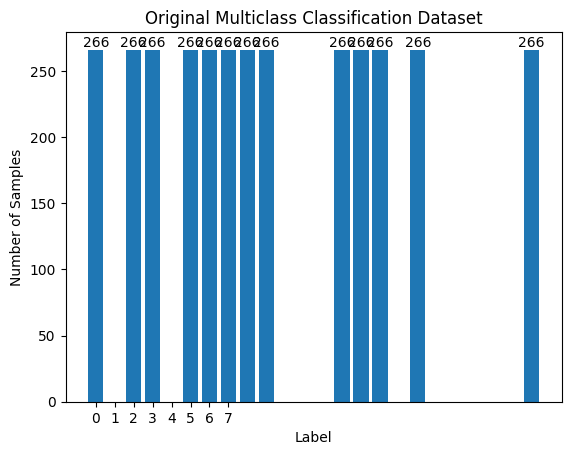

In [ ]:
label_counts = dataset_cropped['Family'].value_counts()

plt.bar(label_counts.index.astype(int), label_counts.values)

plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.title('Original Multiclass Classification Dataset')

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7])

for i, count in enumerate(label_counts.values):
    plt.text(label_counts.index[i], count, str(count), ha='center', va='bottom')

plt.show()

In [ ]:
data = dataset_cropped.to_numpy()
x = data[:, :-1].astype(float)
y = data[:, -1].astype(float)

In [ ]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
import datetime

y_cat = to_categorical(y)
start_time = datetime.datetime.now()

avg_p = []
avg_a = []
avg_r = []
avg_f = []

for i in range(10):
  print("Running iteration number:", i)
  x_train, x_test, y_train, y_test = train_test_split(x, y_cat, test_size=0.2)

  model = Sequential()
  model.add(Dense(512, input_dim=71, activation = "relu"))
  model.add(Dense(256, activation = "relu"))
  model.add(Dense(128, activation = "relu"))
  model.add(Dropout(0.2))
  model.add(Dense(24, activation = "softmax"))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', TopKCategoricalAccuracy(k=3)])
  model.fit(x_train, y_train, verbose=1, epochs=100, batch_size=30)

  predict_x=model.predict(x_test)
  y_pred_class=np.argmax(predict_x,axis=1)

  y_pred = model.predict(x_test)
  y_test_class = np.argmax(y_test, axis=1)

  precision = precision_score(y_test_class, y_pred_class, average='weighted')
  accuracy = accuracy_score(y_test_class, y_pred_class)
  recall = recall_score(y_test_class, y_pred_class, average='weighted')
  f1 = f1_score(y_test_class, y_pred_class, average='weighted')

  avg_p.append(precision)
  avg_a.append(accuracy)
  avg_r.append(recall)
  avg_f.append(f1)

end_time = datetime.datetime.now()
elapsed_time = end_time - start_time

Running iteration number: 0
Epoch 1/100
93/93 [==============================] - 2s 8ms/step - loss: 1.7868 - accuracy: 0.4892 - top_k_categorical_accuracy: 0.6761
Epoch 2/100
93/93 [==============================] - 1s 6ms/step - loss: 1.0562 - accuracy: 0.6790 - top_k_categorical_accuracy: 0.8572
Epoch 3/100
93/93 [==============================] - 0s 5ms/step - loss: 0.9127 - accuracy: 0.7086 - top_k_categorical_accuracy: 0.8735
Epoch 4/100
93/93 [==============================] - 0s 5ms/step - loss: 0.8292 - accuracy: 0.7354 - top_k_categorical_accuracy: 0.8883
Epoch 5/100
93/93 [==============================] - 0s 5ms/step - loss: 0.7746 - accuracy: 0.7542 - top_k_categorical_accuracy: 0.8988
Epoch 6/100
93/93 [==============================] - 0s 4ms/step - loss: 0.7404 - accuracy: 0.7617 - top_k_categorical_accuracy: 0.9096
Epoch 7/100
93/93 [==============================] - 0s 5ms/step - loss: 0.7047 - accuracy: 0.7690 - top_k_categorical_accuracy: 0.9150
Epoch 8/100
93/93 [=

In [ ]:
print(f'The time needed is: {elapsed_time}')
print(f'The precision mean after 10 runs is: {np.mean(avg_p)}')
print(f'The accuracy mean after 10 runs is: {np.mean(avg_a)}')
print(f'The recall mean after 10 runs is: {np.mean(avg_r)}')
print(f'The F1 mean after 10 runs is: {np.mean(avg_f)}')

The time needed is: 0:10:42.230201
The precision mean after 10 runs is: 0.7683100969745394
The accuracy mean after 10 runs is: 0.7482658959537573
The recall mean after 10 runs is: 0.7482658959537573
The F1 mean after 10 runs is: 0.7508218450378333
